# LCLUC XGBoost

In [1]:
# Import packages
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rioxr
import xarray as xr
import rasterstats
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint

pd.set_option('display.max_columns', None)


In [2]:
# Read in data
wrk_dir = Path.cwd().parent # go up a directory with parent
data_path = os.path.join(wrk_dir, 'data')

# Labels
all_label_data = pd.read_parquet(os.path.join(data_path, 'all_label_data.parquet'))

# Rasters - open as Dataset first
rasters_ds = xr.open_dataset(os.path.join(data_path, 'rasters_stack.nc'))

# Check what variables are in the dataset
print("Variables in dataset:", list(rasters_ds.data_vars))
# We want the second item in this list

Variables in dataset: ['spatial_ref', '__xarray_dataarray_variable__']


In [3]:
# Extract the main data variable
rasters = rasters_ds['__xarray_dataarray_variable__']
# rasters = rasters_ds[list(rasters_ds.data_vars)[0]]

print(f"Loaded {len(rasters.band)} bands")
print(f"Bands: {rasters.band.values}")

Loaded 50 bands
Bands: ['coastal_areosol_L30' 'blue_L30' 'green_L30' 'red_L30' 'NIR_narrow_L30'
 'SWIR1_L30' 'SWIR2_L30' 'cirrus_L30' 'TIR1_L30' 'TIR2_L30'
 'coastal_areosol_S30' 'blue_S30' 'green_S30' 'red_S30' 'red_edge_1_S30'
 'red_edge_2_S30' 'red_edge_3_S30' 'NIR_broad_S30' 'NIR_narrow_S30'
 'SWIR1_S30' 'SWIR2_S30' 'water_vapor_S30' 'cirrus_S30' 'blue_evi_l30'
 'blue_evi_s30' 'VV' 'VH' 'VV_VH' 'dem_band_0' 'dem_band_1' 'dem_band_2'
 'dem_band_3' 'dem_band_4' 'dem_band_5' 'GLCM_mean_red'
 'GLCM_variance_red' 'GLCM_homogeneity_red' 'GLCM_contrast_red'
 'GLCM_dissimilarity_red' 'GLCM_entropy_red' 'GLCM_second_moment_red'
 'GLCM_correlation_red' 'GLCM_mean_nir' 'GLCM_variance_nir'
 'GLCM_homogeneity_nir' 'GLCM_contrast_nir' 'GLCM_dissimilarity_nir'
 'GLCM_entropy_nir' 'GLCM_second_moment_nir' 'GLCM_correlation_nir']


In [4]:
# Create data set with only forest and non-forest labels 
def subset_labels(df, classes):
    """
    Create dataset with specified classes, combining all others as 'nonforest'
    """
    # Create a copy to avoid modifying original
    subset = df.copy()
    
    # Replace class values: keep if in classes list, otherwise set to 'nonforest'
    subset['class'] = subset['class'].apply(
        lambda x: x if x in classes else 'nonforest'
    )
    
    # Convert class column to categorical
    subset['class'] = subset['class'].astype('category')
    
    return subset

forest = subset_labels(all_label_data, ['forest'])
forest_water_bare = subset_labels(all_label_data, ['forest', 'water', 'bare'])

In [5]:
print(f"{forest['class'].value_counts()}\n")
print(forest_water_bare['class'].value_counts())

class
nonforest    1030
forest        270
Name: count, dtype: int64

class
nonforest    670
bare         270
forest       270
water         90
Name: count, dtype: int64


For the forest/non-forest, definitely have a class imbalance that should be considered in the model design...

In [8]:
forest.isna().sum()

class                      0
coastal_areosol_L30       19
blue_L30                  19
green_L30                 19
red_L30                   19
NIR_narrow_L30            19
SWIR1_L30                 19
SWIR2_L30                 19
cirrus_L30                19
TIR1_L30                  19
TIR2_L30                  19
coastal_areosol_S30        0
blue_S30                   0
green_S30                  0
red_S30                    0
red_edge_1_S30             0
red_edge_2_S30             0
red_edge_3_S30             0
NIR_broad_S30              0
NIR_narrow_S30             0
SWIR1_S30                  0
SWIR2_S30                  0
water_vapor_S30            0
cirrus_S30                 0
blue_evi_l30              19
blue_evi_s30               0
VV                         0
VH                         0
VV_VH                      0
dem_band_0                 0
dem_band_1                 0
dem_band_2                 0
dem_band_3                 0
dem_band_4                 0
dem_band_5    

## Model Design

In [5]:
# Impute missing values
forest_clean = forest.drop(columns=['GLCM_correlation_nir', 'GLCM_contrast_red'])

# Separate features and target
X = forest_clean.drop(columns=['class'])
y = forest_clean['class']

# Scale to avoid warnings when imputing
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Impute remaining NAs using KNN
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42, stratify=y)  # Ensures both train/test have same class ratios


### Step 2: Determine best number of trees using early stopping
As a guard against overfitting while maximizing performance, we use **early stopping**. We start with a large number of trees and allow XGBoost to determine the optimal number by stopping training when the validation error no longer improves.

The choice of hyperparameter starting values is important in this process. We begin with:
- `n_estimators=1000` to ensure the model has enough capacity to learn meaningful patterns.
- `learning_rate=0.1` as a reasonable default that balances learning speed and performance.
- `eval_metric="logloss"` as the metric of performance to optimize.
- `early_stopping_rounds=50` to halt training if no improvement is seen for 50 rounds, preventing unnecessary computations.
- `random_state = 808`

We then `fit()` our specified baseline model, passing in the training sets as usual and specifying validation sets values for the `eval_set` parameter.

Finally, get and print the best number of trees from the fitted baseline model.


In [ ]:
# Initialize XGB model
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1, 
    early_stopping_rounds=50, 
    eval_metric="logloss", 
    random_state=808)

# Fit model
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

In [ ]:
# Feature Importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

                feature  importance
10  coastal_areosol_S30    0.167140
24         blue_evi_s30    0.126484
11             blue_S30    0.098665
5             SWIR1_L30    0.067222
2             green_L30    0.055974
1              blue_L30    0.044298
14       red_edge_1_S30    0.044013
6             SWIR2_L30    0.036907
20            SWIR2_S30    0.032166
12            green_S30    0.031920


In [ ]:
# See what the best parameter selections were
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_split': 5,
 'n_estimators': 100}

In [19]:
# Initiate model with best parameters
best_rf_model = RandomForestClassifier(
    **grid_search.best_params_,
    n_jobs=-1,
    random_state = 808
)

In [29]:
# Fit model
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

      forest       0.99      0.98      0.98        81
   nonforest       0.99      1.00      1.00       309

    accuracy                           0.99       390
   macro avg       0.99      0.99      0.99       390
weighted avg       0.99      0.99      0.99       390


Confusion matrix:
[[ 79   2]
 [  1 308]]

Accuracy score: 0.9923


In [ ]:
rasters_subset = rasters.drop_sel(band=['GLCM_correlation_nir', 'GLCM_contrast_red'])


In [ ]:
# Stack rasters into numpy array
raster_stack = rasters_subset.values  # shape: (bands, y, x)
n_bands, height, width = raster_stack.shape

# Reshape to (n_pixels, n_bands)
raster_2d = raster_stack.reshape(n_bands, -1).T


In [ ]:
# Convert to DataFrame with proper column names
raster_df = pd.DataFrame(raster_2d, columns=rasters_subset.band.values)

# Apply same scaling transformation used during training
raster_scaled = pd.DataFrame(
    scaler.transform(raster_df),
    columns=raster_df.columns
)

# Impute NAs in raster data
raster_imputed = pd.DataFrame(
    imputer.transform(raster_scaled), 
    columns=raster_scaled.columns
)


In [ ]:
# Chunk for efficiency
chunk_size = 100000
predictions = []

for i in range(0, len(raster_imputed), chunk_size):
    chunk = raster_imputed.iloc[i:i+chunk_size]
    pred_chunk = best_rf_model.predict(chunk)
    predictions.extend(pred_chunk)

predictions = np.array(predictions)


In [ ]:
# Recode to Numeric
label_map = {'forest': 1, 'nonforest': 0}
predictions_numeric = np.array([label_map.get(p, -1) for p in predictions])

# Reshape back to raster dimensions
prediction_raster = predictions_numeric.reshape(height, width)

# Handle NaN values - set to a nodata value
prediction_raster = prediction_raster.astype(float)  # Keep as float to preserve NaN
nodata_value = -9999
prediction_raster = np.where(np.isnan(prediction_raster), nodata_value, prediction_raster)


In [ ]:
# Prep for output
output = rasters.isel(band=0).copy()  # Template from first band
output.values = prediction_raster

# Clear all attributes and set only what's needed
output.attrs = {}
output.attrs['long_name'] = 'forest_prediction'

# Set nodata value
# output.rio.write_nodata(nodata_value, inplace=True)

# Write out tif
output.rio.to_raster(os.path.join(data_path, 'output', 'forest_prediction.tif'))

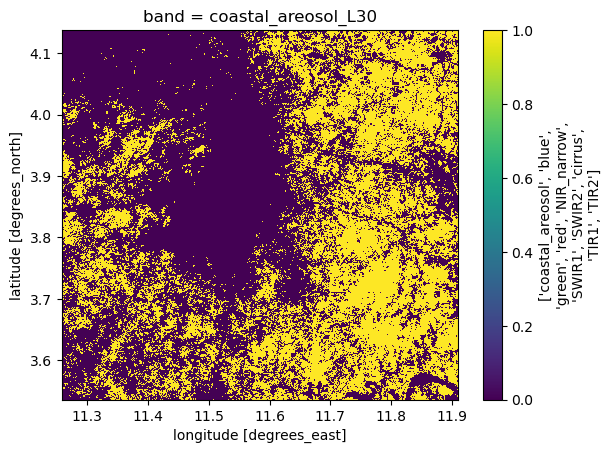

In [65]:
output.plot()